# Facemask detection
The goal of this deep learning challenge is to reach an accuracy as high as possible. The minimal accuracy we aim for is 80%. A side goal is to see if we could correctly classify on pictures of ourselves where we are or are not wearing masks, and if time permits, make an interactive demo of our model where you can try to classify whether you are wearing a mask live on webcam.

## Preparation
In this section useful libraries are imported which are used in most data science projects.

In [1]:
import os
import sys
import PIL
import PIL.Image

# sets the path to the home directory of this repository so other modules can be imported. 
root_path = os.path.split(os.getcwd())[0]
assert root_path.endswith("mask-detection"), "The root path does not end with mask-detection: " + root_path 
sys.path.insert(0, root_path)

import numpy as np
import tensorflow as tf

# set the seed for reproducible results.
np.random.seed(42)
tf.random.set_seed(42)

# optionally, set TensorFlow to use the GPU with all available memory.
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data collection
The data we are using is from a Kaggle data challenge. <br>
https://www.kaggle.com/altaga/facemaskdataset <br>
We are using the official kaggle API to download the dataset and unzip the dataset to the data folder.

In [2]:
!kaggle datasets download -p data/ -d altaga/facemaskdataset
!unzip -n data/facemaskdataset.zip -d data/

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


# Preparing the data
The images from the facemask dataset are not all in the same size.

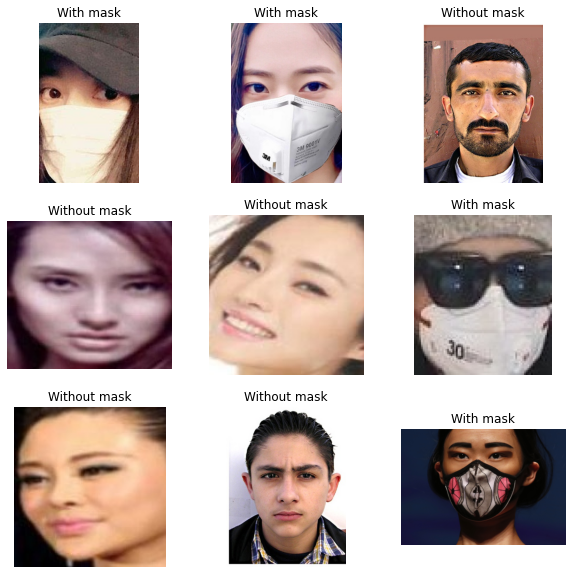

In [3]:
import pathlib
import matplotlib.pyplot as plt

path = pathlib.Path(root_path + '/data/facemask-dataset')
image_paths = tf.data.Dataset.list_files(str(path/'*/*'), shuffle=True).batch(10)

plt.figure(figsize=(10, 10))
for image_paths in image_paths.take(1):
  for i in range(9):
    image_path = image_paths[i].numpy()
    masked = "Without mask"
    if "yes" in str(image_path):
        masked = "With mask"
    image = PIL.Image.open(image_path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(masked)
    plt.axis("off")

In [4]:
from datasets.facemask_dataset import FacemaskDataset
batch_size = 64
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
facemaskDataset = FacemaskDataset(path, batch_size, 200, 200, False, train_percentage, validation_percentage, test_percentage)

train: 36 validation: 12 test: 12


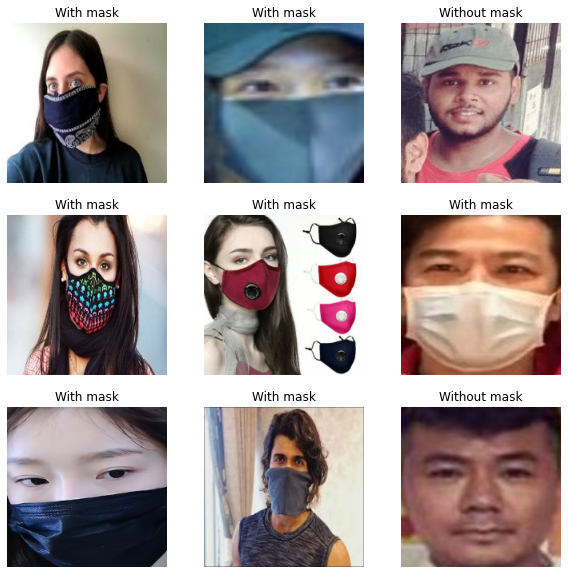

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in facemaskDataset.train_ds.take(1):
  for i in range(9):
    masked = "Without mask"
    if labels[i]:
        masked = "With mask"
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(masked)
    plt.axis("off")

# Exploratory Data Analysis
Explore the data to gain insights on possible features

# Modelling
Apply ML/DL models

In [6]:
from models.base_model import ModelBase
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

class MyModel(ModelBase):
    def __init__(self, feature_length, gpu_initialized=False, training=False, limit=5000):
        super().__init__(gpu_initialized, training, limit)
        # the name for the model.
        self.name = 'MyModel'

        # sets the feature length for input.
        self.feature_length = feature_length

    def predict(self, X):
        # create predictable array, since predicting only works on an array.
        predictable_array = np.expand_dims(X, axis=0)

        # perform prediction and take the first and only prediction out of the predictions array.
        prediction = self.model.predict(X, verbose=1)[0]
        
        return prediction

    def fit(self, training, callbacks, epochs, validation, validation_steps, steps_per_epoch):
        self.model.fit(
            training,
            callbacks=callbacks,
            epochs=epochs,
            validation_data=validation,
            validation_steps=validation_steps,
            steps_per_epoch=steps_per_epoch, verbose=0)

    def compile(self, optimizer='adam', loss='mse', metrics=['mse'], loss_weights=[1.0], show_summary=False):
        inputs = Input((self.feature_length,))

        dense1 = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(inputs)
        outputs = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(dense1)

        # construct the model by stitching the inputs and outputs
        self.model = Model(inputs=inputs, outputs=outputs, name=self.name)

        # compile the model
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

        if show_summary:
            self.model.summary()

In [7]:
model = MyModel(myDataset.feature_length, training=True, gpu_initialized=True)

NameError: name 'myDataset' is not defined

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

epochs = 512
INIT_LR = 1e-4
opt = Adam(lr = INIT_LR, decay = INIT_LR / epochs)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['mse', 'accuracy'], show_summary=True)

# current time
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# create logging
log_dir = os.path.join(project_path, f'logs\{model.name}\{current_time}')

# create all callbacks
callbacks = [
  EarlyStopping(patience=50, monitor='val_loss'),
  TensorBoard(log_dir=log_dir, profile_batch=0)
]

In [ ]:
%load_ext tensorboard

In [ ]:
# fit the model using the training data
results = model.fit(
  training=myDataset.train_ds,
  callbacks=callbacks,
  epochs=epochs,
  validation=myDataset.val_ds,
  validation_steps=myDataset.val_size,
  steps_per_epoch=myDataset.train_size)
  
# save the weights of the model
weights_path = os.path.join(project_path, f'models\{model.name}_trained_model_weights')
model.save_weights(weights_path)

# Validation
Validate the model performance

In [ ]:
# re initialize the model.
model.training = False
model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['mse', 'accuracy'], show_summary=False) 
model.load_weights(weights_path)

print('\n# Evaluate on test data')
result = model.evaluate(myDataset.actual_test_ds)
print('test loss, test acc:', result)
res = dict(zip(model.get_metric_names(), result))
print(res)